# Benchmarking with Sparse

In [1]:
from typing import NamedTuple, Callable
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from doe_modules.preferences import kwarg_savefig, outputdir, kwarg_err
from doe_modules.simulation import (
    Sparse, kappa, BenchmarkingPipeline, 
    DOptimizationBenchmarkingPipeline
)

In [2]:
class Config(NamedTuple):
    savefig: bool = True
    out: str = outputdir
    configuration: dict = {
        "_sparse": {"simulator": Sparse}
    }
    noise_arr: list = [.5, 1, 2, 4]
    n_range: np.ndarray = np.arange(1, 11)
    n_rep: int = 30
    dunnett: bool = True
    evaluation_metric: Callable = kappa
    metric_name: str = "Cohen's $\kappa$"
    N: int = 3
    n_add: list = np.arange(2, 7).astype(int)
    extension: str = ".pdf"

conf = Config()

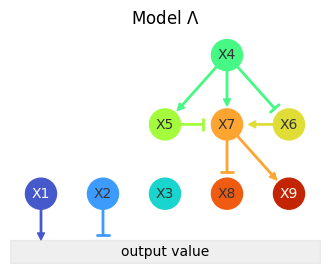

In [3]:
for suffix, d in conf.configuration.items():

    fig, ax = plt.subplots(figsize=(4, 3))

    d["simulator"]().plot(ax=ax)
    ax.set_title(d["simulator"]().name)

    if conf.savefig:
        fig.savefig(f"{conf.out}/sim_model{suffix}{conf.extension}", **kwarg_savefig)

In [4]:
pipe = BenchmarkingPipeline(
    configuration=conf.configuration,
    noise_arr=conf.noise_arr,
    n_range=conf.n_range,
    n_rep=conf.n_rep,
    dunnett=conf.dunnett,
    evaluation_metric=conf.evaluation_metric,
    metric_name=conf.metric_name
)

Running benchmarking pipeline:   0%|          | 0/1 [00:00<?, ?it/s]

generating simulated results with experimental designs:   0%|          | 0/2 [00:00<?, ?it/s]

encoding simulated results with MLR/AVOVA:   0%|          | 0/2 [00:00<?, ?it/s]

evaluating experimental design performance:   0%|          | 0/3 [00:00<?, ?it/s]

pb-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

cloo-based simulators:   0%|          | 0/1200 [00:00<?, ?it/s]

dunnett's test:   0%|          | 0/1200 [00:00<?, ?it/s]

power analysis:   0%|          | 0/3 [00:00<?, ?it/s]

Plotting:   0%|          | 0/3 [00:00<?, ?it/s]

plot_groundtruth:   0%|          | 0/1 [00:00<?, ?it/s]

plot_benchmarking:   0%|          | 0/1 [00:00<?, ?it/s]

plot_power:   0%|          | 0/1 [00:00<?, ?it/s]

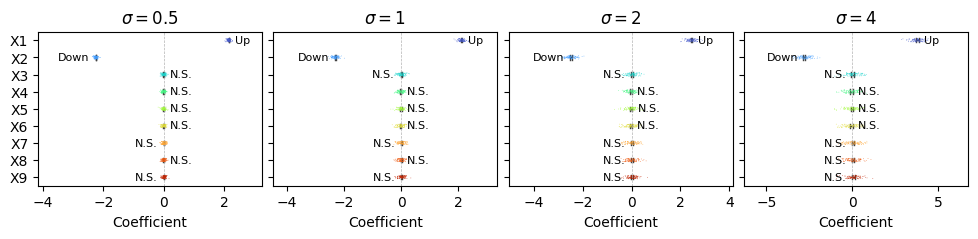

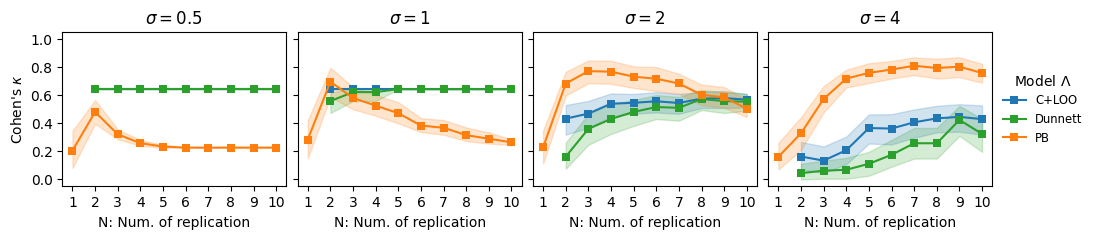

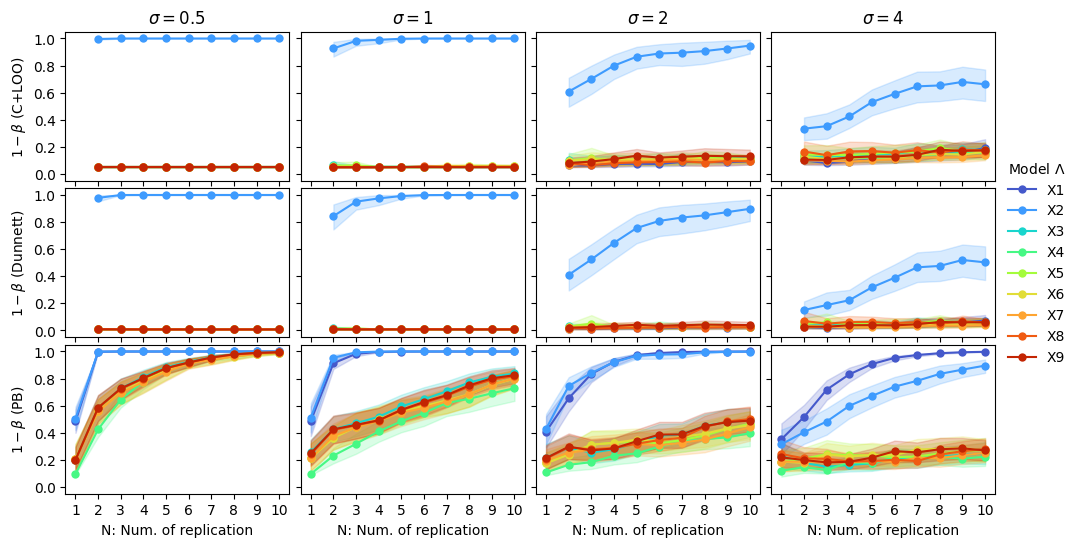

In [5]:
pipe.plot(savefig=conf.savefig, extension=conf.extension)

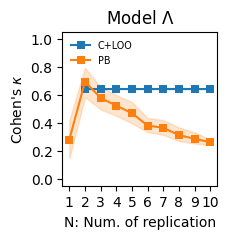

In [6]:
for suffix, bm in pipe.configuration.items():
    
    fig, ax = bm.plot_benchmarking(
        unit_x_length=2, unit_y_length=2,
        noise=1, show_dunnet=False
    )
    
    if conf.savefig:
        fig.savefig(f"{conf.out}/benchmarks_default{suffix}{conf.extension}", **kwarg_savefig)

In [7]:
dopipe = DOptimizationBenchmarkingPipeline(
    from_pipeline=pipe,
    N=conf.N,
    n_add=conf.n_add
)

Running D-optimization pipeline:   0%|          | 0/1 [00:00<?, ?it/s]

generating simulated results with experimental designs:   0%|          | 0/1 [00:00<?, ?it/s]

encoding simulated results with MLR/AVOVA:   0%|          | 0/1 [00:00<?, ?it/s]

calculating n_max values:   0%|          | 0/1 [00:00<?, ?it/s]

evaluating experimental design performance:   0%|          | 0/1 [00:00<?, ?it/s]

evaluating D-criterion values:   0%|          | 0/1 [00:00<?, ?it/s]

Power analysis:   0%|          | 0/1 [00:00<?, ?it/s]

Plotting:   0%|          | 0/2 [00:00<?, ?it/s]

plot_benchmarking:   0%|          | 0/1 [00:00<?, ?it/s]

plot_power:   0%|          | 0/1 [00:00<?, ?it/s]

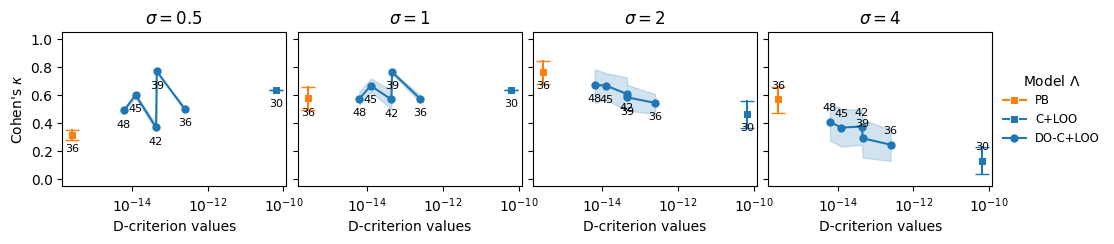

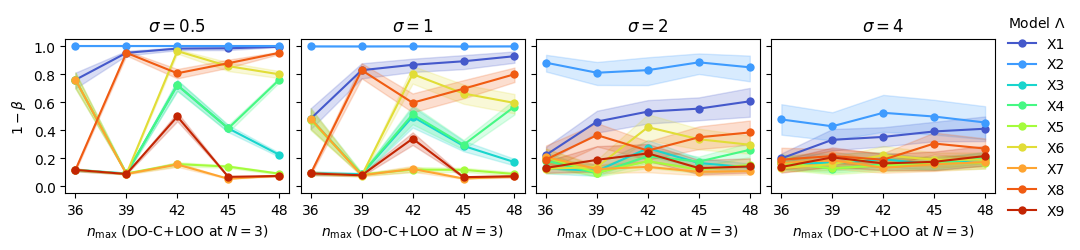

In [8]:
dopipe.plot(savefig=conf.savefig, extension=conf.extension)